In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import functools

import numpy as np
import scipy as sp
import matplotlib.pylab as plt
from typing import Callable, Iterator, Sequence
import functools

import numpy as np
import scipy as sp
import matplotlib.pylab as plt

import jax.numpy as jnp
import jax.scipy as jsp
import jax
import flax.linen as nn
import optax
import haiku as hk
import chex
import tqdm
import numpy as np

rng = np.random.default_rng()
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


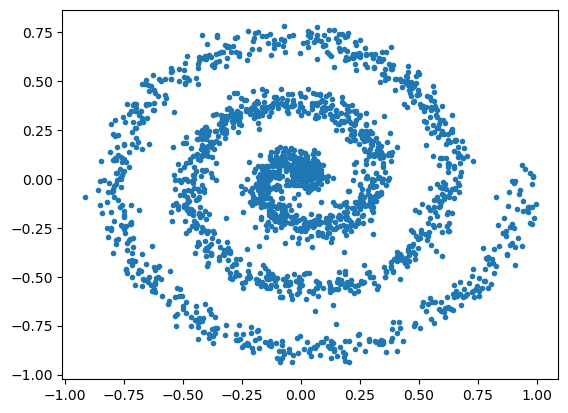

In [3]:
def generate_spiral(*, num: int, rng: np.random.Generator) -> np.ndarray:
    thetas = rng.uniform(low=0.0, high=6*np.pi, size=(num,))
    rs = thetas * 0.05
    X = np.hstack((
        (rs * np.cos(thetas))[:, None],
        (rs * np.sin(thetas))[:, None],
    ))
    X = X + 0.04 * rng.standard_normal(X.shape) 
    return X

X = generate_spiral(num=2000, rng=rng)
plt.plot(X[:, 0], X[:, 1], ".")

In [4]:
Activation = Callable[[jax.Array], jax.Array]

class MLP(nn.Module):

    features: Sequence[int]
    activation: Activation = nn.swish

    @nn.compact
    def __call__(self, x: jax.Array) -> jax.Array:
        for f in self.features[:-1]:
            x = nn.Dense(f)(x)
            x = self.activation(x)
        x = nn.Dense(self.features[-1])(x)
        return x

model = MLP(features=[128, 512, 2])
optimizer = optax.adam(learning_rate=0.0003)
prng_seq = hk.PRNGSequence(jax.random.PRNGKey(0))


def denoise_score_matching_loss(
    params: chex.ArrayTree, batch: jax.Array, noise: jax.Array, sigma=0.1
) -> float:
    def compute_loss(noise_slice):
        fs = model.apply(params, batch + noise_slice * sigma)
        return jnp.mean(jnp.square(fs * sigma + noise_slice))

    vactorized_loss_computation = jax.vmap(compute_loss, in_axes=(-1,), out_axes=0)
    losses = vactorized_loss_computation(noise)
    loss = jnp.sum(losses)
    return loss

@jax.jit
def do_batch_update(
    batch: jax.Array,
    params: chex.ArrayTree,
    opt_state: optax.OptState,
    noise: jax.Array,
) -> tuple[float, chex.ArrayTree, optax.OptState]:
    loss, grad = jax.value_and_grad(denoise_score_matching_loss)(params, batch, noise)
    updates, opt_state = optimizer.update(grad, opt_state)
    params = optax.apply_updates(params, updates)
    return loss, params, opt_state


class BatchManager(Iterator[np.ndarray]):

    def __init__(self, data: np.ndarray, batch_size: int, key: chex.PRNGKey):
        batch_size = min(batch_size, len(data))
        self._num_batches = len(data) // batch_size
        self._batch_idx = None
        self._batch_size = batch_size
        self._key = hk.PRNGSequence(key)
        self._data = data
        self._reset()

    @property
    def num_batches(self) -> int:
        return self._num_batches

    def _reset(self) -> None:
        self._perm = np.array(
            jax.random.permutation(next(self._key), np.arange(len(self._data)))
        )
        self._batch_idx = 0

    def __next__(self) -> np.ndarray:
        assert self._batch_idx is not None
        assert self._batch_idx >= 0 and self._batch_idx < self._num_batches
        inds = self._perm[
            self._batch_idx
            * self._batch_size : (self._batch_idx + 1)
            * self._batch_size
        ]
        batch = self._data[inds]
        k = 100
        noise = jax.random.normal(next(self._key), batch.shape + (k,))
        self._batch_idx += 1
        if self._batch_idx >= self._num_batches:
            self._reset()
        return batch, noise

In [5]:
train_data = X
validation_data =generate_spiral(num=500, rng=rng)

params = model.init(next(prng_seq), train_data[:1, ...])
opt_state = optimizer.init(params)
bm = BatchManager(data=train_data, batch_size=32, key=next(prng_seq))
validation_bm = BatchManager(data=validation_data, batch_size=32, key=next(prng_seq))

training_losses = []
validation_losses = []
iterations_per_epoch = 100
totEpochs = 40000 // iterations_per_epoch
for epoch in tqdm.tqdm(range(totEpochs)):
    epoch_losses = []
    validation_epoch_losses=[]
    for _ in range(iterations_per_epoch):
        batch, noise = next(bm)
        loss, params, opt_state = do_batch_update(batch, params, opt_state, noise)
        epoch_losses.append(loss)

    avg_epoch_loss = np.mean(epoch_losses)
    training_losses.append(avg_epoch_loss)
    
    for _ in range(iterations_per_epoch):
        batch, noise = next(validation_bm)
        validation_loss, params, opt_state = do_batch_update(batch, params,opt_state, noise)  
        validation_epoch_losses.append(validation_loss)

    avg_validation_loss = np.mean(validation_epoch_losses)
    validation_losses.append(avg_validation_loss)

training_losses = np.array(training_losses)
validation_losses = np.array(validation_losses)

100%|██████████| 400/400 [28:32<00:00,  4.28s/it]    


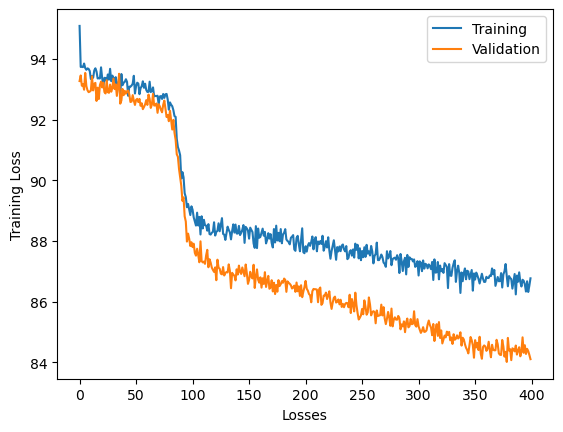

In [7]:
plt.plot(training_losses,label="Training")
plt.plot(validation_losses, label="Validation")
plt.ylabel("Training Loss")
plt.xlabel("Losses")
plt.legend(loc="upper right")
plt.show()

In [8]:
@functools.partial(jax.jit, static_argnames=("num_steps",))
def langevin_sampling(
    params: chex.ArrayTree,
    key: chex.PRNGKey,
    step_size: float,
    initial_samples: jax.Array,
    num_steps: int,
) -> jax.Array:

    def scan_fn(carry, _):
        states, key = carry
        key, sk = jax.random.split(key)
        noise = jax.random.normal(sk, shape=states.shape)
        next_states = states + step_size * model.apply(params, states) + jnp.sqrt(2 * step_size) * noise
        return (next_states, key), None

    states = initial_samples
    (states, _), _ = jax.lax.scan(scan_fn, (states, key), jnp.arange(num_steps))
    return states
samples = langevin_sampling(params,next(prng_seq),5e-3,
    2 * jax.random.normal(next(prng_seq), shape=(2000, 2)), 1000)

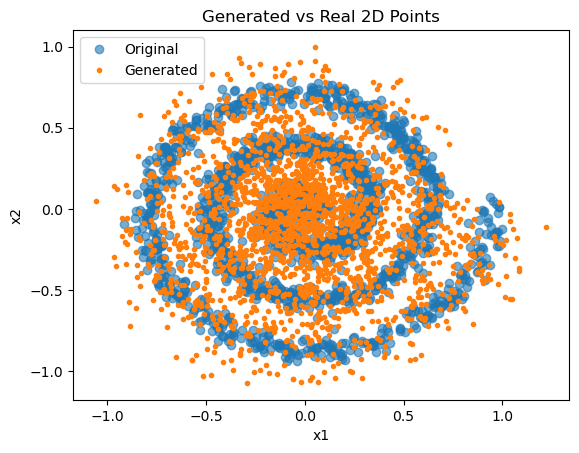

In [10]:
plt.title('Generated vs Real 2D Points')
plt.plot(X[:, 0], X[:, 1], 'o', alpha=0.6,label="Original")
plt.plot(samples[:, 0], samples[:, 1], '.',label="Generated")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend(loc="upper left")
plt.show()

In [28]:
from flax import serialization
import os
def save_model(params, model_path='saved_model.pkl'):
    serialized_params = serialization.to_bytes(params)
    with open(model_path, 'wb') as f:
        f.write(serialized_params)

save_model(params, 'dsm_pin.pkl')

In [38]:
'''
def load_model(model_path='saved_model.pkl'):
    # Load the serialized parameters from the file
    with open(model_path, 'rb') as f:
        serialized_params = f.read()
    
    # Deserialize the parameters
    params = serialization.from_bytes(model.init(random.PRNGKey(0), jnp.ones((1, 2))), serialized_params)
    return params

# Example usage:
loaded_params = load_model('my_model_path.pkl')

# Example function to generate data using loaded parameters
def generate_data(params, num_samples):
    samples = jax.random.normal(jax.random.PRNGKey(1), shape=(num_samples, 2))
    generated_data = model.apply(params, samples)
    return generated_data

# Generate data
new_data = generate_data(loaded_params, 1000)
plt.plot(new_data[:, 0], new_data[:, 1], ".")
plt.show()
'''

'\ndef load_model(model_path=\'saved_model.pkl\'):\n    # Load the serialized parameters from the file\n    with open(model_path, \'rb\') as f:\n        serialized_params = f.read()\n    \n    # Deserialize the parameters\n    params = serialization.from_bytes(model.init(random.PRNGKey(0), jnp.ones((1, 2))), serialized_params)\n    return params\n\n# Example usage:\nloaded_params = load_model(\'my_model_path.pkl\')\n\n# Example function to generate data using loaded parameters\ndef generate_data(params, num_samples):\n    samples = jax.random.normal(jax.random.PRNGKey(1), shape=(num_samples, 2))\n    generated_data = model.apply(params, samples)\n    return generated_data\n\n# Generate data\nnew_data = generate_data(loaded_params, 1000)\nplt.plot(new_data[:, 0], new_data[:, 1], ".")\nplt.show()\n'

In [11]:
np.save("dsm_spiral.npy",samples)